# References

https://www.kaggle.com/code/moritzkronberger/snn-0-94-acc/notebook
https://towardsdatascience.com/sign-language-recognition-with-advanced-computer-vision-7b74f20f3442
https://github.com/mg343/Sign-Language-Detection/blob/main/camerahands.py

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import random
import numpy as np
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import pandas as pd
from sklearn.preprocessing import LabelBinarizer

In [80]:
retrain = False

train_df = pd.read_csv("data/sign_mnist_train.csv")
test_df = pd.read_csv("data/sign_mnist_test.csv")

In [81]:
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']



In [82]:
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

x_train = train_df.values
x_test = test_df.values

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(27455, 28, 28, 1)
(27455, 24)
(7172, 28, 28, 1)
(7172, 24)


In [83]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [84]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 28, 28, 75)        750       
                                                                 
 batch_normalization_9 (Batc  (None, 28, 28, 75)       300       
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 75)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 50)        33800     
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_10 (Bat  (None, 14, 14, 50)      

In [85]:
if retrain:
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)
    history = model.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 20 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])
    model.save('smnist.h5')
else:
    model = load_model('smnist.h5')

In [86]:
amount_of_samples = 12

# Pick 10 random images for test data set
random.seed(3) # to make this deterministic
sample_indexes = random.sample(range(len(x_test)), amount_of_samples)
sample_images = [x_test[i] for i in sample_indexes]
sample_labels = [y_test[i] for i in sample_indexes]

ground_truth = np.argmax(sample_labels, axis=1)

X_sample = np.array(sample_images)
prediction = model.predict(X_sample)
predicted_categories = np.argmax(prediction, axis=1)
predicted_categories

1/1 [==============================] - 0s 86ms/step


array([14, 12,  1, 19, 15, 22, 20, 22, 13, 17,  3, 13])

In [87]:
# Display the predictions and the ground truth visually.

def display_prediction (images, true_labels, predicted_labels):
    fig = plt.figure(figsize=(20, amount_of_samples +10))
    for i in range(len(true_labels)):
        truth = true_labels[i]
        prediction = predicted_labels[i]
        plt.subplot(amount_of_samples, 4,1+i)
        plt.axis('off')
        color='green' if truth == prediction else 'red'
        plt.text(30, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction),
                 fontsize=12, color=color)
        plt.imshow(images[i])




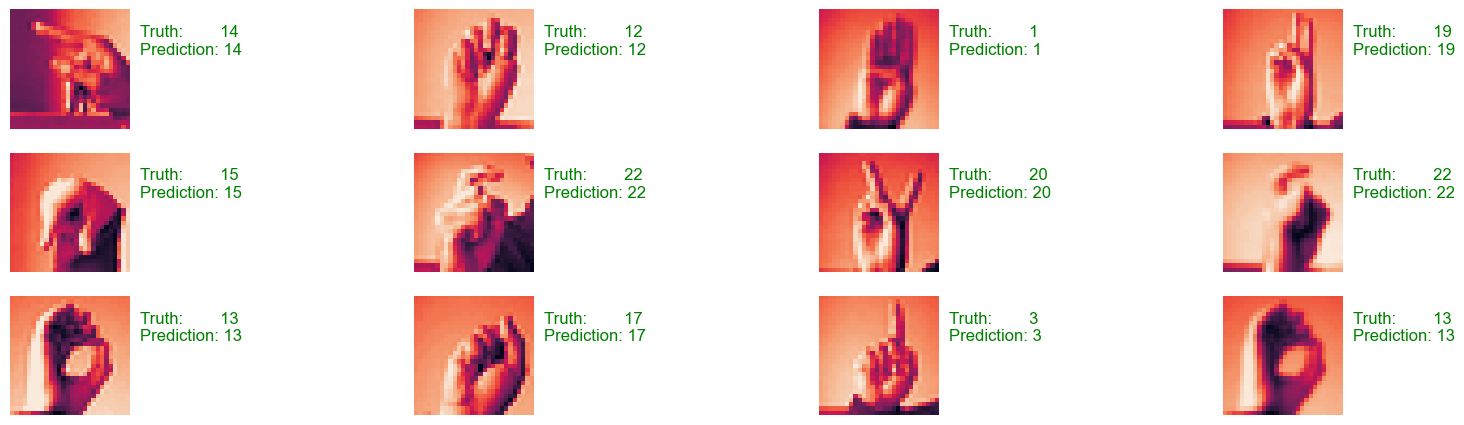

In [88]:
display_prediction(sample_images, ground_truth, predicted_categories)

In [89]:
ground_truth, predicted_categories

(array([14, 12,  1, 19, 15, 22, 20, 22, 13, 17,  3, 13]),
 array([14, 12,  1, 19, 15, 22, 20, 22, 13, 17,  3, 13]))

In [90]:
german_data = pd.read_csv("data/german/german_sign_language.csv")
label_enc = german_data.label.unique()
german_data.label = german_data.label.replace(label_enc, list(range(0,24)))




ds_y = german_data.label.array
ds_y = pd.factorize(ds_y)[0]
ds_y = np.array(ds_y)

ds_x = german_data.drop(['label'], axis=1)
ds_x = ds_x.to_numpy()

In [91]:
num_samples = len(german_data)
classes = pd.unique(german_data.label)
print(f'Samples: {num_samples}')
print(f'Classes: {classes}')

Samples: 7306
Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [92]:
print(ds_y.shape)
print(ds_x.shape)

(7306,)
(7306, 63)


In [93]:
num_samples = ds_x.shape[0]
dim = 3
landmarks = 21 # Orignal 21
test = 10
ds_x = ds_x.reshape((num_samples, landmarks, dim))
print(ds_x.shape)

(7306, 21, 3)


In [94]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(ds_x, ds_y, test_size=0.2, random_state=42)




print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)



(5844, 21, 3)
(5844,)
(1462, 21, 3)
(1462,)


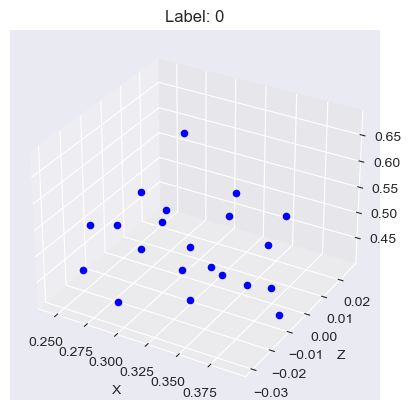

In [95]:
num = 10
example = ds_x[num]
label = ds_y[num]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for vec in example:
    ax.scatter(vec[0], vec[2], vec[1], color='b')

plt.title(f'Label: {classes[label]}')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')

plt.show()

In [96]:
# hyperparameters
epochs = 10
val_split = .2

# labels to one hot
from keras.utils import to_categorical

y_train = to_categorical(y_train.astype(int))
y_test = to_categorical(y_test.astype(int))

print(y_train.shape)
print(y_test.shape)

# create callbacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_acc',
                           restore_best_weights=True,
                           patience=10,
                           verbose=0)

reduce_lr = ReduceLROnPlateau(monitor='val_acc',
                              factor=0.2,
                              min_lr=0.00001,
                              patience=5,
                              verbose=0)

(5844, 24)
(1462, 24)


In [97]:
from keras import Input, Model
from keras.layers import Dense, Flatten, AlphaDropout, LayerNormalization

inputs = Input(shape=x_train[0].shape, name='Landmark_Vectors')

layerNorm = LayerNormalization(name='LayerNorm')(inputs)

flatten = Flatten(name='Flatten_Vectors')(layerNorm)

dense_count = 6
dense_base = 48
out = flatten

for i in range(dense_count):
    units = (dense_count-i) * (dense_count-i) * dense_base
    dense = Dense(units,
                  kernel_initializer="lecun_normal",
                  bias_initializer="zeros",
                  activation='selu',
                  name=f'Dense_{i+1}')
    a_dropout = AlphaDropout(0.05, name=f'Dropout_{i+1}')
    out = dense(out)
    out = a_dropout(out)

outputs = Dense(y_train[0].shape[0], activation='softmax', name='Output_Vector')(out)
model = Model(inputs=inputs, outputs=outputs, name="SNN_6")
model.summary()

Model: "SNN_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Landmark_Vectors (InputLaye  [(None, 21, 3)]          0         
 r)                                                              
                                                                 
 LayerNorm (LayerNormalizati  (None, 21, 3)            6         
 on)                                                             
                                                                 
 Flatten_Vectors (Flatten)   (None, 63)                0         
                                                                 
 Dense_1 (Dense)             (None, 1728)              110592    
                                                                 
 Dropout_1 (AlphaDropout)    (None, 1728)              0         
                                                                 
 Dense_2 (Dense)             (None, 1200)              207480

In [98]:
from keras.optimizers import Adam
if retrain:
    adam = Adam(learning_rate=0.001, beta_2=0.99, epsilon=0.01)

    model.compile(loss='categorical_crossentropy',
                      optimizer=adam,
                      metrics=['acc'])

    history = model.fit(x_train, y_train,
                            epochs=500,
                            batch_size=64,
                            validation_split=val_split,
                            callbacks=[early_stop, reduce_lr])

    model.save("german_dataset.h5")
else:
    model = load_model("german_dataset.h5")


In [99]:
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print(f'*'*11 + "Test data" + 11*"*" +f"\nloss={loss:.4f} acc={acc:.4f}")

***********Test data***********
loss=0.3409 acc=0.9391


46/46 [==============================] - 0s 5ms/step


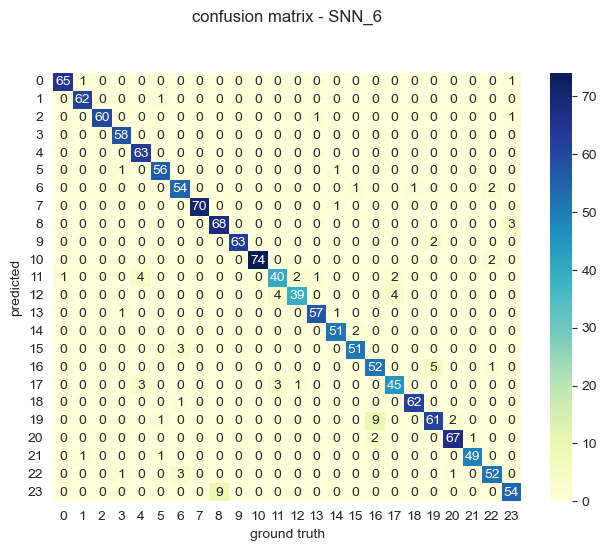

In [100]:
from sklearn import metrics
import seaborn as sns

predictions = model.predict(x_test)
prediction_classes = np.argmax(predictions, axis=-1)

gt_classes = np.argmax(y_test, axis=-1)
confusion_matrix = metrics.confusion_matrix(gt_classes, prediction_classes)

sns.heatmap(pd.DataFrame(confusion_matrix, index=classes, columns=classes), annot=True, cmap="YlGnBu", fmt='d')
plt.tight_layout()
plt.title('confusion matrix - ' + model.name, y=1.1)
plt.ylabel('predicted')
plt.xlabel('ground truth')
plt.show()

In [101]:
if retrain:
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(history.history['acc'], label='train acc')
    plt.plot(history.history['val_acc'], label='val acc')
    plt.legend()

In [102]:
amount_of_samples = 12

# Pick 10 random images for test data set
random.seed(3) # to make this deterministic
sample_indexes = random.sample(range(len(x_test)), amount_of_samples)
sample_images = [x_test[i] for i in sample_indexes]
sample_labels = [y_test[i] for i in sample_indexes]

ground_truth = np.argmax(sample_labels, axis=1)

X_sample = np.array(sample_images)
prediction = model.predict(X_sample)
predicted_categories = np.argmax(prediction, axis=1)
predicted_categories, ground_truth

1/1 [==============================] - 0s 17ms/step


(array([11,  5,  3,  0, 10, 10, 14,  2, 13,  6,  1,  7]),
 array([11,  1,  3,  0, 10, 10, 14,  2, 11,  6,  1,  7]))